<b>Shor's Algorithm</b>

In this notebook, we will introduce and explain Shor's Algorithm. As we previously mentioned, Shor's Algorithm uses some elements we also have explained, too, like Quantum Fourier Transform, or Quantum Phase Estimation.  
  
Shor's Algorithm is famous for being able to factor big integers in polynomial time, something that classical algorithms cannot, because is considered a NP problem that cannot be resolved and verified in polynomial time.  
  
The aim of this algorithm is to find the period of any function, and this can be applied to a lot of problems like, for example, the period finding we mentioned above.  
  
To solve the problem of factoring a large integer, we will first compute the period of that function, that automatically gives us the possibility to do that factoring: $a^x\bmod N$. This function has a period behavior, because we have that property we can take advantage of to find the period:  
  
$a^r \bmod N = 1$  
  
Here, we can see that, every r times, this function result returns to 1. That's the periodic behavior we want to understand and we want to find.  
  
If we take as an example a = 35 and N = 35:  
  
$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$  
  
Once we apply 12 times the exponentiation on 3, the result of the function is 1. Then, if we repeat this (3^24 mod 35), we will obtain again 1.

Here we have a representation of the circuit that we will have to implement in Python:  
  
<img src="https://qiskit.org/textbook/ch-algorithms/images/shor_circuit_1.svg">

First of all, we will apply Hadamart gate on all qubits of first register, and then we will apply the Unitary Operator on all qubits of second register when control qubit is 1, and finally we will apply the inverse QFT on first register to measure it.  
  
As a example for the code, we will take as a = 7 and N = 15. So, we will start by doing an import of all packages we will need to develop the code:

In [8]:
from qiskit import QuantumCircuit, assemble, Aer, transpile
from qiskit.visualization import plot_histogram
import numpy as np
from math import pi

Then, it's time to define the U-controlled gate that we have to apply at the second step. We won't explain the method, simply we will use this function that we can find in Qiskit Tutorial at Shor's Algorithm (https://qiskit.org/textbook/ch-algorithms/shor.html):

In [9]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]: # numbers that don't have inverse are not able to use
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    '''Do the square repeat method to compute a^power mod 15'''        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

We will also take from the tutorial page the generic function to create a circuit that implements the inverse QFT, because we did with one specific number of qubits, but now there will be more in our specific problem:

In [10]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

And now we can build the entire circuit. We will use 8 qubits for the first register (counting register), and 4 for the second (Unitary operator register):

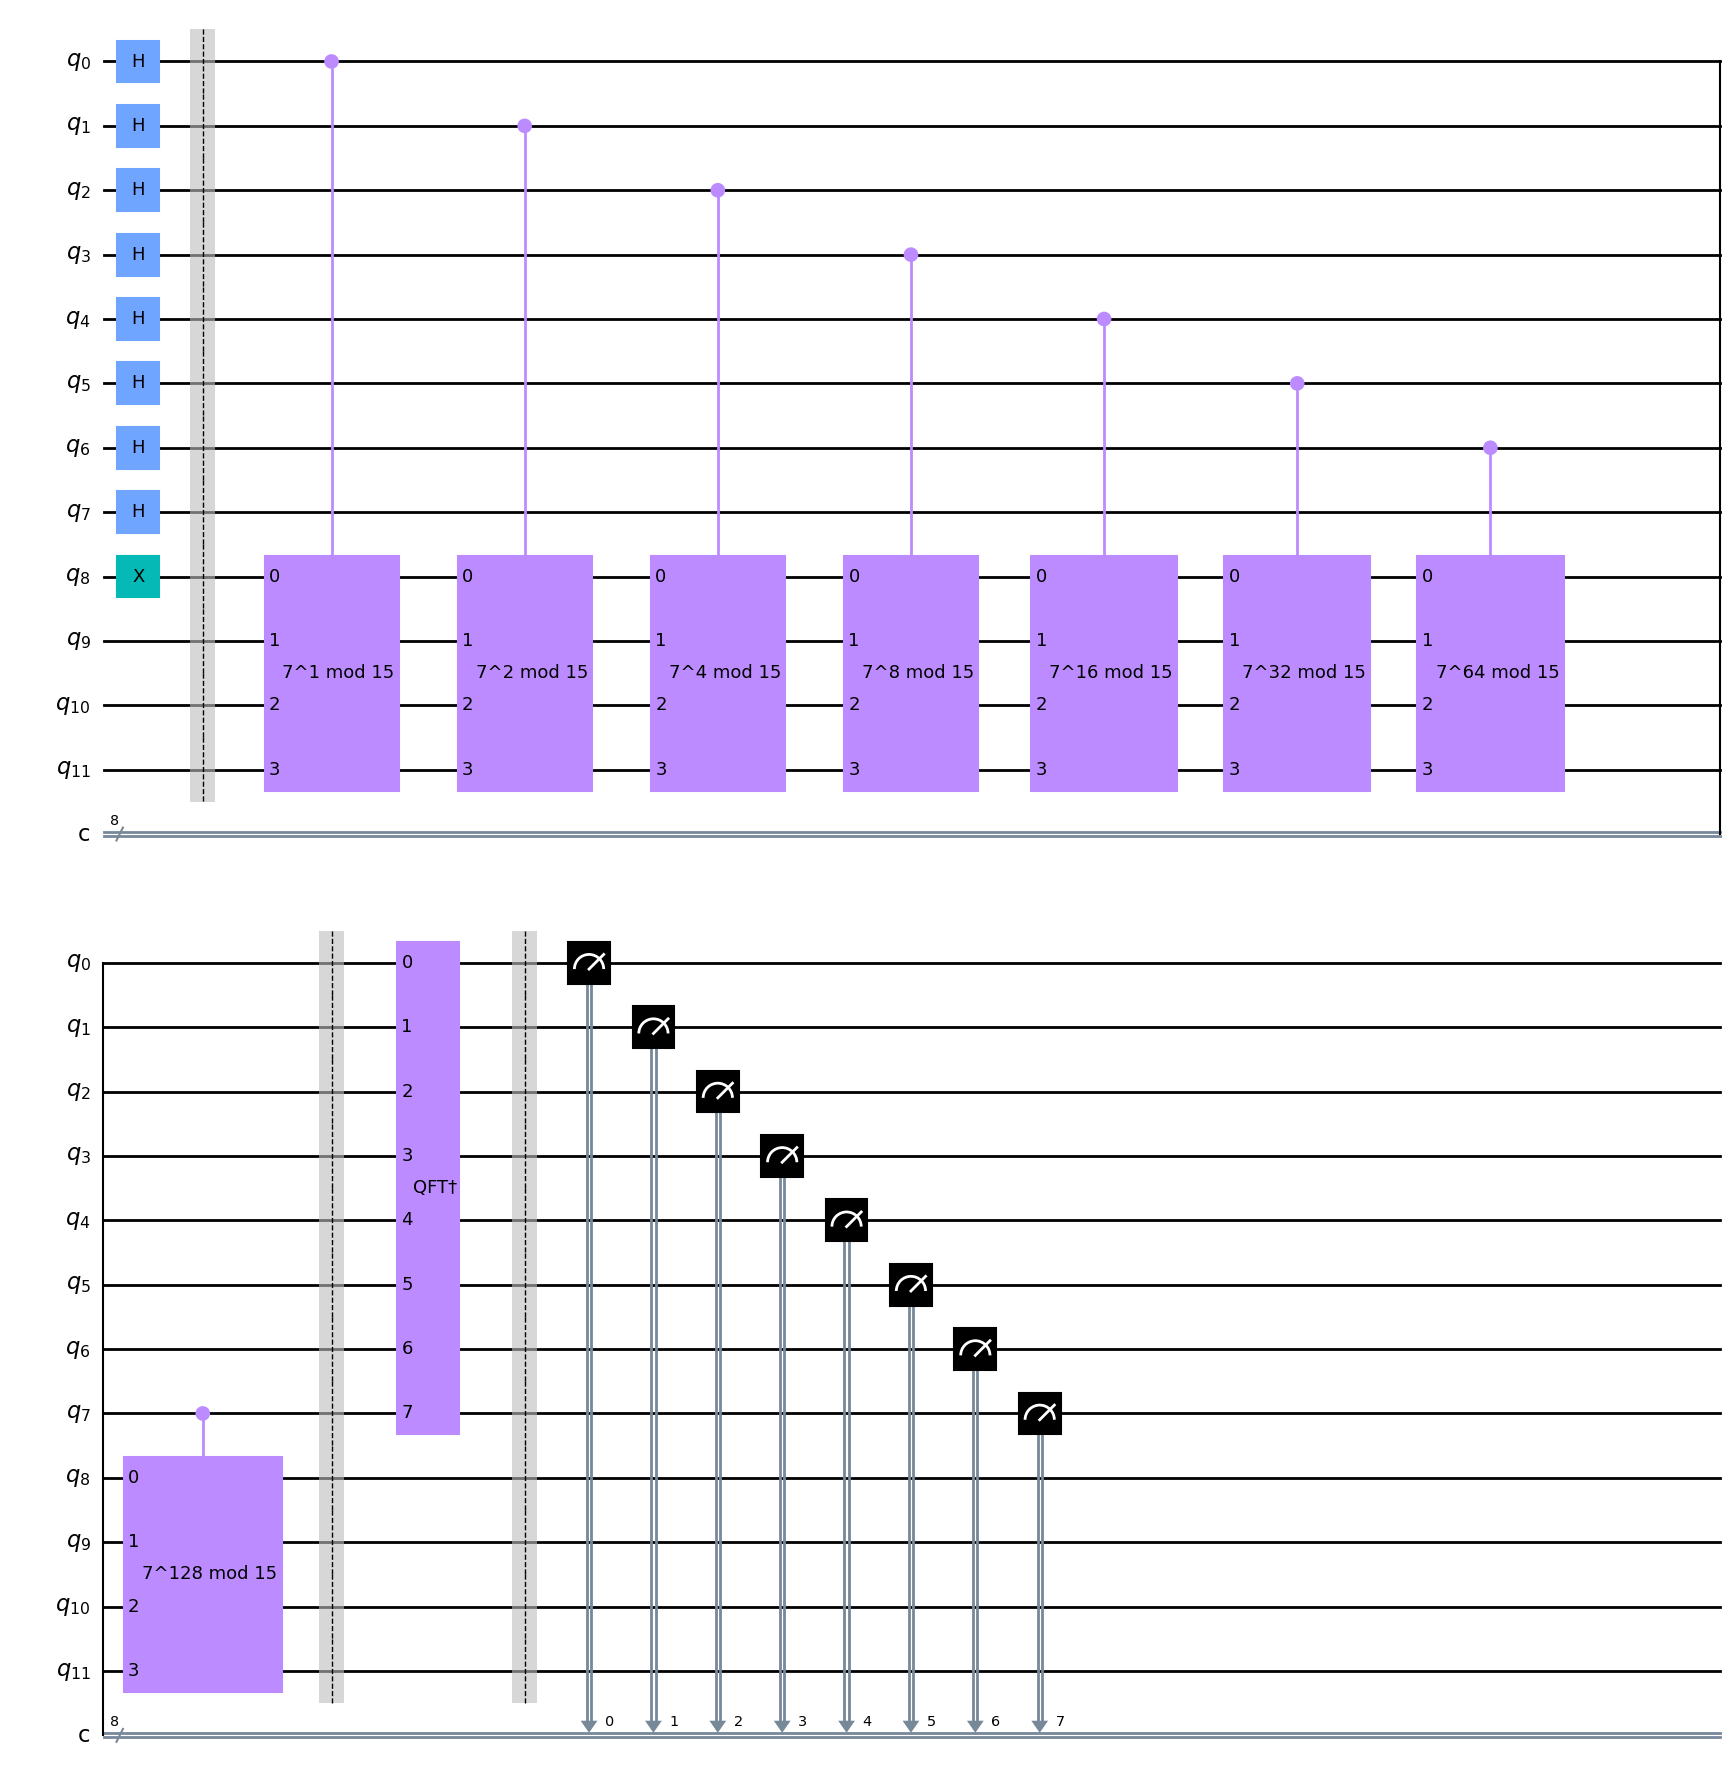

In [11]:
algorithm = QuantumCircuit(12, 8)

'''put all qubits in first register in state |+>'''
algorithm.h([0,1,2,3,4,5,6,7])

'''put second register in state |1>'''
algorithm.x(8)
algorithm.barrier()

'''apply U-controlled gates'''
algorithm.append(c_amod15(7, 2**0), 
             [0] + [i+8 for i in range(4)])
algorithm.append(c_amod15(7, 2**1), 
             [1] + [i+8 for i in range(4)])
algorithm.append(c_amod15(7, 2**2), 
             [2] + [i+8 for i in range(4)])
algorithm.append(c_amod15(7, 2**3), 
             [3] + [i+8 for i in range(4)])
algorithm.append(c_amod15(7, 2**4), 
             [4] + [i+8 for i in range(4)])
algorithm.append(c_amod15(7, 2**5), 
             [5] + [i+8 for i in range(4)])
algorithm.append(c_amod15(7, 2**6), 
             [6] + [i+8 for i in range(4)])
algorithm.append(c_amod15(7, 2**7), 
             [7] + [i+8 for i in range(4)])
algorithm.barrier()

'''apply inverse QFT'''
algorithm.append(qft_dagger(8), range(8))
algorithm.barrier()

'''measure first register'''
algorithm.measure([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])
algorithm.draw(output='mpl')

Then, we will execute the circuit on simulator and see the results:

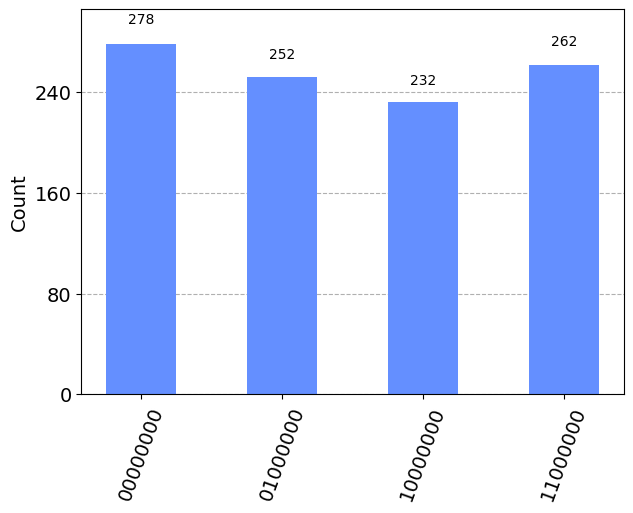

In [13]:
simulator = Aer.get_backend('aer_simulator')
t_qc = transpile(algorithm, simulator)
qobj = assemble(t_qc)
histogram = simulator.run(qobj).result().get_counts()
plot_histogram(histogram)

Here we obtained 4 different values. Now, to know the phase, we will use a relation between the estimated phase ($\theta = \frac{x}{2^n}$) and the real phase ($\phi = \frac{s}{r}$).  
  
Shor's Algorithm gave us 4 different phases:  
00000000(bin) =   0(dec)    0/256 = 0.00  
01000000(bin) =  64(dec)   64/256 = 0.25  
11000000(bin) = 192(dec)  192/256 = 0.75  
10000000(bin) = 128(dec)  128/256 = 0.50  

So, now we can find the period r knowing that r cannot be bigger than N (the module). In our case is 15, so r (the denominator part of the fraction) cannot be bigger than 15, so we have to transform all that fractions into lowest terms:  
  
0.00   ->   0/1   -> r = 1  
0.25   ->   1/4   -> r = 4  
0.75   ->   3/4   -> r = 4  
0.50   ->   1/2   -> r = 2  
  
And we obtained 2 same results, that indicates that r is 4, the correct period for 7^x mod 15. Note that Shor's Algorithm also gives us wrong results, but this can be solved by repeating the execution many times until we are sure about the correct result.